In [1]:
import xmltodict
from urllib.request import urlopen
import xml.etree.ElementTree as ET
import pandas as pd

from dateutil.parser import parse

import matplotlib.pyplot as plt
from IPython.display import display 
from joblib import Parallel, delayed
import multiprocessing

import urllib
from bs4 import BeautifulSoup
    
plt.style.use('seaborn-paper')
%matplotlib inline

In [2]:
link = 'http://clerk.house.gov/evs/{session}/roll{roll}.xml'

link_list = []

congress_session  = {'2018' : 129,
                     '2017' : 710,
                     '2016' : 622,
                     '2015' : 705, 
                     '2014' : 564,
                     '2013' : 641,
                     '2012' : 659,
                     '2011' : 949,
                     '2010' : 664,
                     '2009' : 991,
                     '2008' : 690,
                     '2007' : 1186,
                     '2006' : 543,
                     '2005' : 671,
                     '2004' : 544,
                     '2003' : 677,
                     '2002' : 484,
                     '2001' : 512,
                     '2000' : 603
                    }

for session, roll  in congress_session.items():
    print(session, roll)
    for i in range (1, roll + 1):
        temp = link.replace('{session}', session)
        temp = temp.replace('{roll}', '{:03}'.format(i))
        link_list.append(temp)

print('link_list', len(link_list))
print(link_list[1])

2014 564
2012 659
2004 544
2009 991
2000 603
2007 1186
2001 512
2015 705
2002 484
2016 622
2010 664
2008 690
2018 129
2005 671
2006 543
2017 710
2003 677
2011 949
2013 641
link_list 12544
http://clerk.house.gov/evs/2014/roll002.xml


In [3]:
#         <majority>D</majority>
#         <congress>103</congress>
#         <session>1st</session>
#         <chamber>U.S. House of Representatives</chamber>
#         <rollcall-num>615</rollcall-num>
#         <legis-num>H R 3167</legis-num>
#         <vote-question>On Agreeing to the Conference Report</vote-question>
#         <vote-type>RECORDED VOTE</vote-type>
#         <vote-result>Passed</vote-result>
#         <action-date>22-Nov-1993</action-date>
#         <action-time time-etz="23:59">11:59 PM</action-time>
#         <vote-desc>UNEMPLOYMENT COMPENSATION...</vote-desc>

#         <recorded-vote>
#             <legislator party="D" state="HI" role="legislator">Abercrombie</legislator>
#             <vote>Aye</vote>
#         </recorded-vote>

In [4]:
def xml2df(xml_data):
#     print(xml_data)
    root = ET.XML(xml_data) # element tree
#     print(root)
    vote_metadata = root.find('vote-metadata')
    vote_data = root.find('vote-data').iter('recorded-vote')
    records = []
    
    for vote in vote_data:
        record = {} #Place holder for our record
        record['majority'] = vote_metadata.find('majority').text
        record['congress'] = vote_metadata.find('congress').text
        record['session'] = vote_metadata.find('session').text

        try:
            record['chamber'] = vote_metadata.find('chamber').text
        except Exception:
            record['chamber'] = None

        record['rollcall_num'] = vote_metadata.find('rollcall-num').text
        try:
            record['legis_num'] = vote_metadata.find('legis-num').text
        except Exception:
            record['legis_num'] = None

        record['vote_question'] = vote_metadata.find('vote-question').text
        record['vote_type'] = vote_metadata.find('vote-type').text
        record['vote_result'] = vote_metadata.find('vote-result').text
        record['action_date'] = vote_metadata.find('action-date').text
        record['action_time'] = vote_metadata.find('action-time').text
        record['vote_desc'] = vote_metadata.find('vote-desc').text
    
        record['party'] = vote.find('legislator').attrib['party']
        record['state'] = vote.find('legislator').attrib['state']
        record['role'] = vote.find('legislator').attrib['role']
        record['name'] = vote.find('legislator').text
        record['vote'] = vote.find('vote').text
        records.append(record)
        
    return pd.DataFrame(records)
    
    
# xml = urlopen(link_list[2]).read()
# df = xml2df(xml)
# df.tail()

In [5]:
%%time


def processLink(link):
#     print('processing', link)
    urlContent = urlopen(link)
    xml = urlContent.read()
    return xml2df(xml)

num_cores = multiprocessing.cpu_count()
print('num_cores', num_cores)

# processLink(link_list[2])
    
results = Parallel(n_jobs=num_cores)(delayed(processLink)(i) for i in link_list)

df_votes = pd.concat(results)
df_votes.reset_index(drop=True, inplace=True)

# df_hansard['date'] =  pd.to_datetime(df_hansard['date'])

df_votes.to_csv('data/votes_all.csv')
print(len(df_votes))



num_cores 8
5426370
CPU times: user 39.9 s, sys: 1.99 s, total: 41.9 s
Wall time: 16min 35s


In [6]:
df_votes.tail()

action_date action_time                        chamber congress  \
5426365  12-Dec-2013     6:36 PM  U.S. House of Representatives      113   
5426366  12-Dec-2013     6:36 PM  U.S. House of Representatives      113   
5426367  12-Dec-2013     6:36 PM  U.S. House of Representatives      113   
5426368  12-Dec-2013     6:36 PM  U.S. House of Representatives      113   
5426369  12-Dec-2013     6:36 PM  U.S. House of Representatives      113   

         legis_num majority        name party        role rollcall_num  \
5426365  H RES 441        R     Yarmuth     D  legislator          641   
5426366  H RES 441        R       Yoder     R  legislator          641   
5426367  H RES 441        R        Yoho     R  legislator          641   
5426368  H RES 441        R  Young (AK)     R  legislator          641   
5426369  H RES 441        R  Young (IN)     R  legislator          641   

        session state vote                                          vote_desc  \
5426365     1st    KY  Nay  Providing for concurrence by the House in the ...   
5426366     1st    KS  Yea  Providing for concurrence by the House in the ...   
5426367     1st    FL  Nay  Providing for concurrence by the House in the ...   
5426368     1st    AK  Yea  Providing for concurrence by the House in the ...   
5426369     1st    IN  Yea  Providing for concurrence by the House in the ...   

                                    vote_question vote_result        vote_type  
5426365  On Motion to Suspend the Rules and Agree      Passed  2/3 YEA-AND-NAY  
5426366  On Motion to Suspend the Rules and Agree      Passed  2/3 YEA-AND-NAY  
5426367  On Motion to Suspend the Rules and Agree      Passed  2/3 YEA-AND-NAY  
5426368  On Motion to Suspend the Rules and Agree      Passed  2/3 YEA-AND-NAY  
5426369  On Motion to Suspend the Rules and Agree      Passed  2/3 YEA-AND-NAY

In [7]:
df_votes.describe()

action_date action_time                        chamber congress  \
count       5426370     5426370                        4212068  5426370   
unique         2124         991                              1       10   
top     18-Jun-2009     6:57 PM  U.S. House of Representatives      110   
freq          23106       33715                        4212068   813110   

       legis_num majority        name    party        role rollcall_num  \
count    5422027  5426370     5426370  5426370     5426370      5426370   
unique      4063        2        1118        3           2         1186   
top      JOURNAL        R  Brady (PA)        R  legislator            1   
freq      120613  3896058       12539  2769875     5425517         8235   

        session    state     vote  \
count   5426370  5426370  5426370   
unique        2       51       38   
top         1st       CA      Yea   
freq    3048385   656480  2048292   

                                                vote_desc  \
count                                             3443830   
unique                                               5483   
top     Waiving a requirement of clause 6(a) of rule X...   
freq                                                 9529   

                       vote_question vote_result      vote_type  
count                        5426370     5426370        5426370  
unique                           338           7              6  
top     On Agreeing to the Amendment      Passed  RECORDED VOTE  
freq                         1722237     3154781        2490346

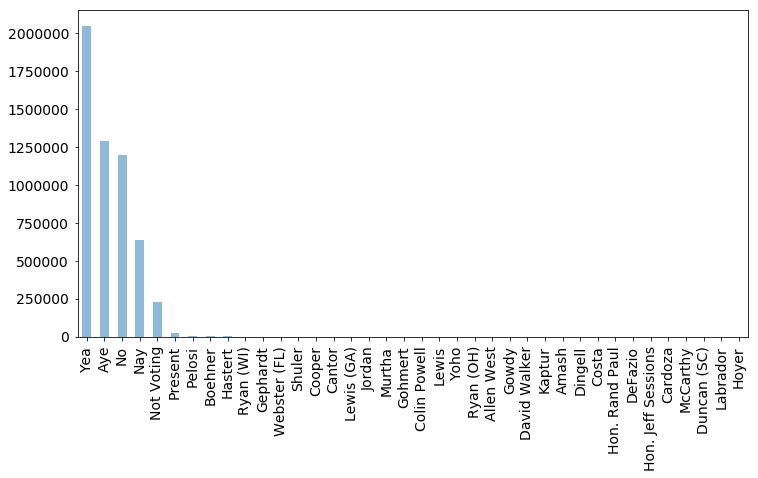

In [8]:
df_votes['vote'].value_counts().plot(kind='bar', alpha=.5, figsize=(12, 6), fontsize=14)

# House bills

In [9]:
%%time


import re
link = 'https://www.congress.gov/bill/{congress}th-congress/house-bill/{billNum}/text?format=txt&r=1'
records = []
congress = '115'
print('bills',  len(df_votes['legis_num'].unique()))
for row in df_votes['legis_num'].unique():

    try:
        record = {}
        link_temp = link.replace('{congress}', congress)
        link_temp = link_temp.replace('{billNum}', ''.join(re.findall('\d+', row)))
        #         print(link_temp)
    
        req = urllib.request.Request(link_temp, headers={'User-Agent' : "Magic Browser"}) 
        htmlContent = urllib.request.urlopen(req).read()
        
        soup = BeautifulSoup(htmlContent, 'lxml')
        billText = soup.find("pre", {"id": "billTextContainer"}).text
        
        record['congress'] = congress
        record['legis_num'] = row
        record['bill_text'] = billText
        record['link'] = link_temp
#         print(congress, row)
        records.append(record)
        
    except Exception:
        pass
#         print('didnt find', link_temp)
        
df_bill = pd.DataFrame(records)
print('found ', len(df_bill), ' out of ', len(df_votes['legis_num'].unique()))
df_bill.to_csv('data/bill_all.csv')
df_bill.tail()

bills 4064
found  3790  out of  4064
CPU times: user 6min 12s, sys: 7.44 s, total: 6min 20s
Wall time: 49min 49s
